In [1]:
import sqlite3
con = sqlite3.connect('SQL.db')
cur = con.cursor()
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
import numpy as np
import nltk
import pandas as pd

In [2]:
s3 = "rating:"
rating_id = []
for r in cur.execute("SELECT website_id, website_content FROM websites"):
    website_id = r[0]
    website_content = r[1]
    try:
        rating_idx = website_content.find(s3)
        if rating_idx > 0:
            rating_id.append((int(website_content[rating_idx+8:rating_idx+9]), website_id))
    except:
        pass


In [3]:
for i in rating_id:
    cur.execute(f"UPDATE websites SET rating = {i[0]} WHERE website_id = {i[1]}")
con.commit()
cur.execute(f"UPDATE websites SET rating = 0 WHERE rating IS NULL")
con.commit()


In [4]:
positive_data = []
for r in cur.execute("SELECT website_id, website_content FROM websites WHERE rating > 3"):
    website_id = r[0]
    website_content = r[1]
    positive_data.append(r[1])

In [5]:
negative_data = []
for r in cur.execute("SELECT website_id, website_content FROM websites WHERE rating BETWEEN 1 AND 3"):
    website_id = r[0]
    website_content = r[1]
    negative_data.append(r[1])

In [6]:
pos_tagged_positive = []

for doc in positive_data:
    try:
        doc = re.sub(r'[^A-Za-z0-9 ]+', '', doc)
        wt = nltk.word_tokenize(doc)
        pos_tagged_positive.append(nltk.pos_tag(wt, tagset = "universal"))
    except:
        pass

In [7]:
pos_tagged_negative = []

for doc in negative_data:
    try:
        doc = re.sub(r'[^A-Za-z0-9 ]+', '', doc)
        wt = nltk.word_tokenize(doc)
        pos_tagged_negative.append(nltk.pos_tag(wt, tagset = "universal"))
    except:
        pass

In [8]:
flat_list_positive = [item for sublist in pos_tagged_positive for item in sublist]
flat_list_negative = [item for sublist in pos_tagged_negative for item in sublist]



In [9]:
#PATTERN DEFINITION & PARSING
pattern = 'NamedEntity: {<DET>?<NOUN|JJ><DET>*<NOUN>}'
cp = nltk.RegexpParser(pattern)
cs_pos = cp.parse(flat_list_positive)
cs_neg = cp.parse(flat_list_negative)
NamedEntitiesPositive = []
NamedEntitiesNegative = []
for p in cs_pos:
    try:
        if p.label() == "NamedEntity":
            NamedEntitiesPositive.append(' '.join([i[0] for i in p.leaves()]))
    except AttributeError:
        continue
for p in cs_neg:
    try:
        if p.label() == "NamedEntity":
            NamedEntitiesNegative.append(' '.join([i[0] for i in p.leaves()]))
    except AttributeError:
        continue

In [10]:
#SORTING NAMED ENTITIES
import numpy as np
values, counts = np.unique(NamedEntitiesPositive, return_counts=True)
SortedCounts = sorted(counts)[::-1]
SortedCountsIndexes =np.argsort(counts)[::-1]
SortedEntitiesPositive = []
forbidden = ["Address", "address", "Please"]
for i in SortedCountsIndexes:
    if not re.search(forbidden[0], values[i]) and not  re.search(forbidden[1], values[i]) and not re.search(forbidden[2], values[i]):
        SortedEntitiesPositive.append(values[i])

In [11]:
values2, counts2 = np.unique(NamedEntitiesNegative, return_counts=True)
SortedCounts = sorted(counts2)[::-1]
SortedCountsIndexes =np.argsort(counts2)[::-1]
SortedEntitiesNegative = []
forbidden = ["Address", "address", "Please"]
for i in SortedCountsIndexes:
    if not re.search(forbidden[0], values[i]) and not  re.search(forbidden[1], values[i]) and not re.search(forbidden[2], values[i]):
        SortedEntitiesNegative.append(values[i])

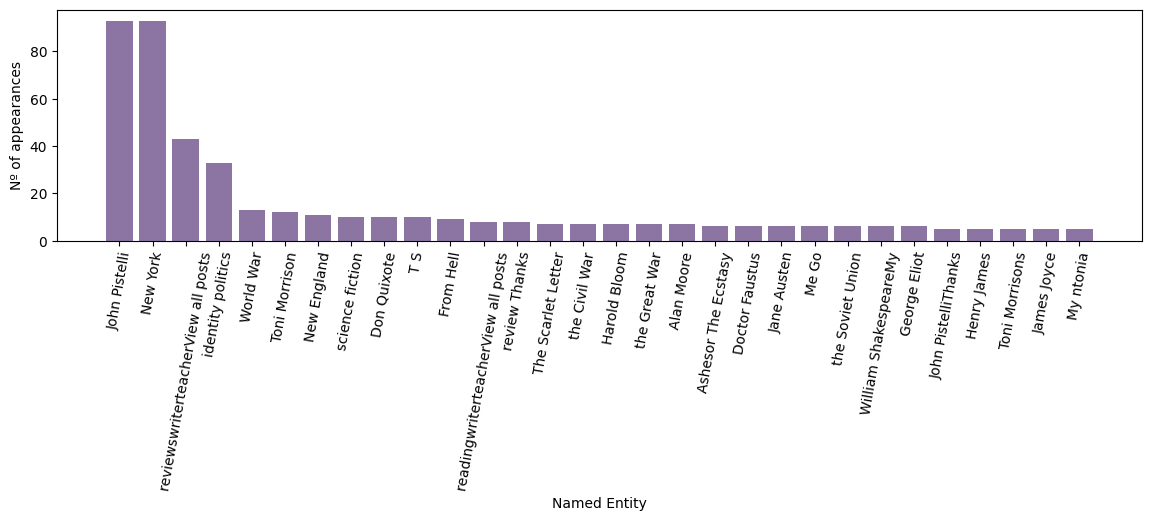

In [12]:
#PLOTING MOST FREQUENT NAMED ENTITIES
import matplotlib.pyplot as plt
plt.style.use('default')
n_palavras = 30
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], SortedCounts[0:n_palavras], color=(0.5, 0.4, 0.6, 0.9))
plt.xticks(eixo_x[0:n_palavras], SortedEntitiesPositive[0:n_palavras], rotation=80)
plt.ylabel('Nº of appearances')
plt.xlabel('Named Entity')
plt.show()

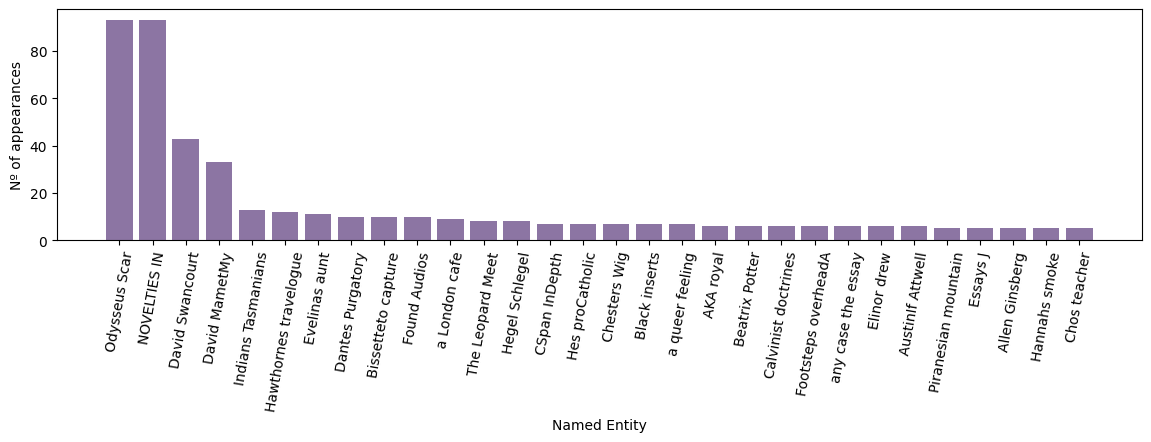

In [13]:
plt.style.use('default')
n_palavras = 30
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], SortedCounts[0:n_palavras], color=(0.5, 0.4, 0.6, 0.9))
plt.xticks(eixo_x[0:n_palavras], SortedEntitiesNegative[0:n_palavras], rotation=80)
plt.ylabel('Nº of appearances')
plt.xlabel('Named Entity')
plt.show()